## Import data

In [1]:
from astropy import constants as const
from astropy import units as u
import math
from astropy.io import fits
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
import matplotlib.pyplot as plt
import numpy as np

from astropy.coordinates import SkyCoord  
from astropy.coordinates import FK5  
from photutils.aperture import SkyEllipticalAperture, SkyRectangularAperture
from photutils.aperture import aperture_photometry


In [2]:
## [INPUT]
## Directory of the data
dir_data = '/Users/donglinwu/Desktop/College/Research/'

hdu_ALMA = fits.open(get_pkg_data_filename(dir_data+'HOPS198_Data/HOPS198_13CO_Tp12m7m_Final_Combine_pbcor.fits'))[0]
cube_header_ALMA = hdu_ALMA.header
cube_data_ALMA = hdu_ALMA.data

wcs_ALMA = WCS(cube_header_ALMA) #WCS axes of spectral cube

wcs2d_ALMA = wcs_ALMA[0, :, :] #Spatial WCS axes
wcsv_ALMA = wcs_ALMA[:,224,224] #Spectral WCS axes

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [3]:
## Spectral axis
v_ALMA =  np.array([wcsv_ALMA.pixel_to_world(int(i)).value/1000 for i in range(cube_data_ALMA.shape[0])])

In [4]:
## [INPUT]
## Import data for the contours

# Contours for the outflow
order_polynomial = 5
num_points = 20
hdu_outflow = fits.open(dir_data+'/HOPS198/outflow/HOPS198_12CO_outflow_mass_order'+str(order_polynomial)+'_nrect_'+str(num_points)+'.fits')[0]
M_outflow_pixel_onto_ALMA = hdu_outflow.data

# Contours for the continuum data
hdu_cont = fits.open(dir_data+'/HOPS198_Data/HOPS-198_Continuum_natural.thres0.11mJy.image.pbcor.fits')[0]
continuum_onto_ALMA = hdu_cont.data

# # Contours for the H2CO infall locations
# hdu_H2CO_infall = fits.open(dir_data+'/HOPS198/H2CO/HOPS198_H2CO_infall.fits')[0]
# loc_H2CO_infall = hdu_H2CO_infall.data



# [IMPORTANT] If the WCS axes are different, reproject the contour onto the WCS axes of the data

from reproject import reproject_exact
hdu_disk = fits.open('/Users/donglinwu/Desktop/College/Research/HOPS198_Data/VANDAM/HOPS-198_cont_robust2.pbcor.fits')[0]
disk_ALMA,_ = reproject_exact((hdu_disk.data[0,0,:,:], WCS(hdu_disk.header)[0,0,:,:]), wcs2d_ALMA)

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in param

In [5]:
## [INPUT] 
## Write down the coordinates of the start and the end of the lines you want to draw on the channel maps

from astropy.coordinates import SkyCoord
from regions import PixCoord, LineSkyRegion, LinePixelRegion

start_sky = SkyCoord("5:35:22.4184354925 -6:13:15.5886744294", frame=FK5, unit=(u.hourangle, u.deg))
end_sky = SkyCoord("5:35:21.9837465772 -6:12:56.6682075823", frame=FK5, unit=(u.hourangle, u.deg))
region_sky = LineSkyRegion(start=start_sky, end=end_sky)
region_pix = region_sky.to_pixel(wcs2d_ALMA)




## Channel maps

In [6]:
## Function that determines how the grid is arranged: (number of columns, number of rows)
## [IMPORTANT] Choose a composite number for the number of channels. E.g. 6, 9, 12. It makes the channel maps a lot nicer.


def close_factors(number):
    ''' 
    find the closest pair of factors for a given number
    '''
    factor1 = 0
    factor2 = number
    while factor1 +1 <= factor2:
        factor1 += 1
        if number % factor1 == 0:
            factor2 = number // factor1
        
    return factor1, factor2


### Large Scale

In [7]:
## [INPUT]
## Channels plotted in the channel map
channels = [62,64,65,66,67,68,69,70,72]

In [8]:
## [INPUT]
## [IMPORTANT] It is important to choose a celestial WCS for the channel maps. 
    ## Otherwise, add_beam function fails, and the size of the beam cannot be shown in the channel maps.
wcs_celestial = WCS(hdu_outflow.header)

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/var/folders/nt/5v93q0kd53nb6_gdg84kfk5w0000gn/T/ipykernel_7664/877187610.py:36: RuntimeWarning: Mean of empty slice
  average_means = np.nanmean(


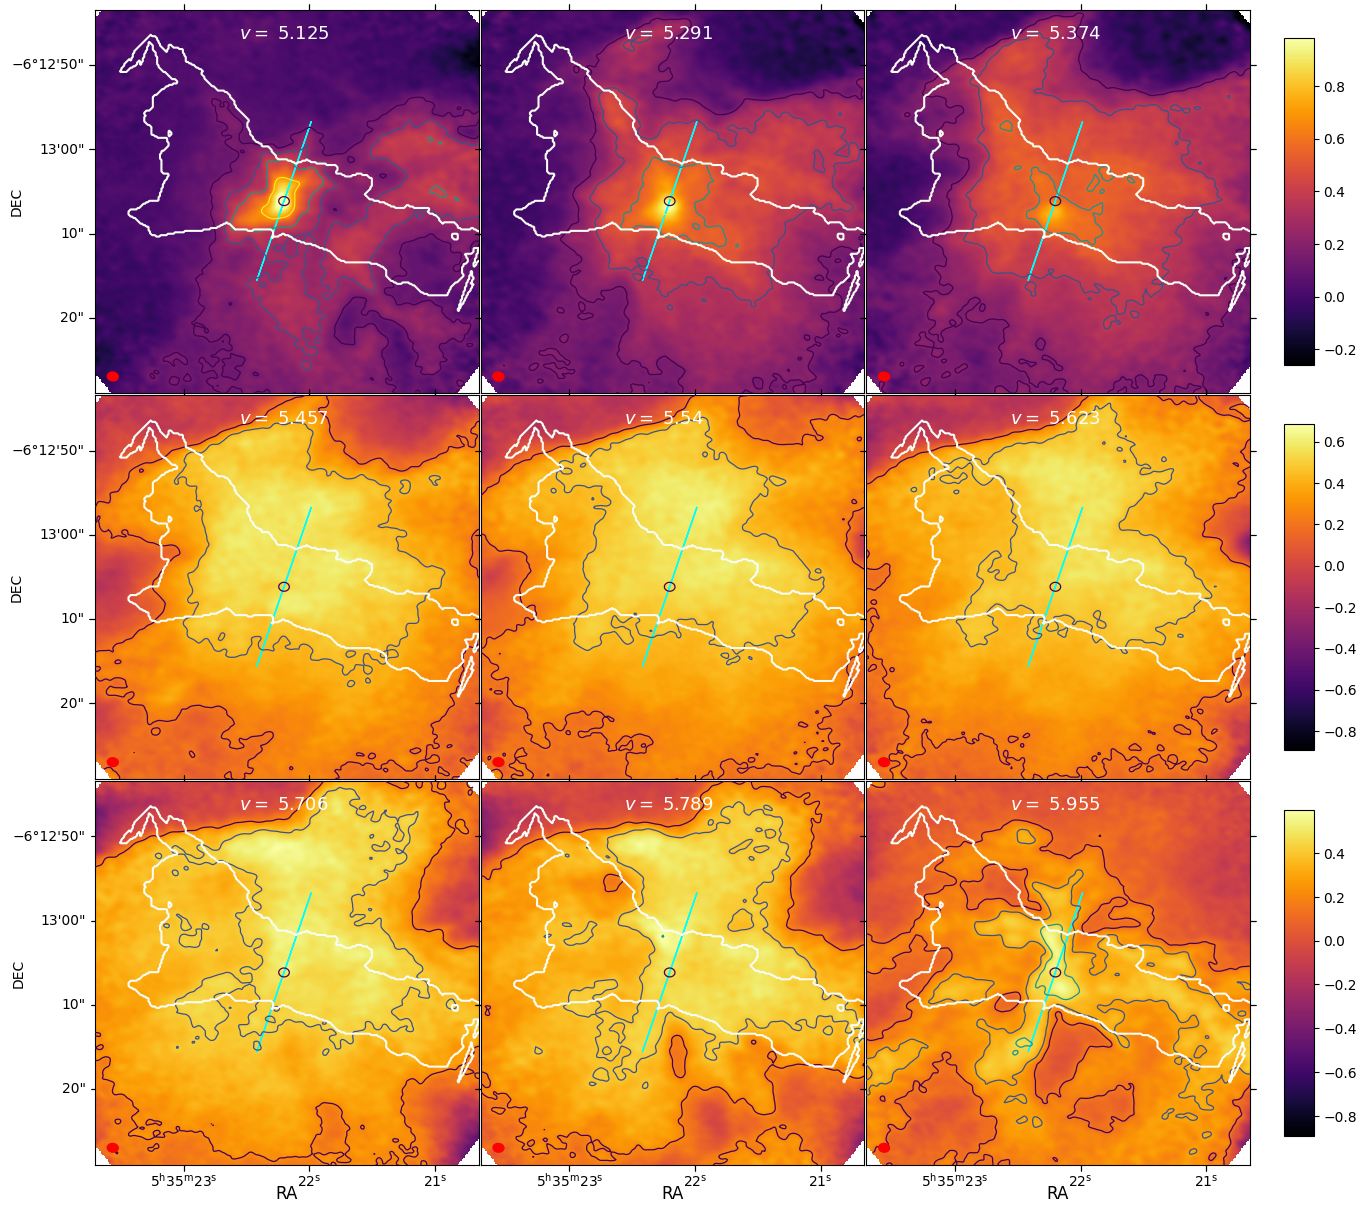

In [9]:
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization.wcsaxes import add_beam
from astropy.visualization import wcsaxes
from astropy.wcs import WCS
import numpy as np
import matplotlib.pyplot as plt
import math

# Determine the number of rows and columns for the grid based on the number of channels.
# close_factors is assumed to return factors (columns, rows) that best fit the number of channels.
n_row, n_col = close_factors(len(channels))[1], close_factors(len(channels))[0]

# Create a figure with a specific size.
fig = plt.figure(figsize=(15, 15))

# Create an ImageGrid for WCS-based subplots.
grid = ImageGrid(fig, 111,
                 nrows_ncols=(n_row, n_col),
                 ngrids=None,
                 direction='row',
                 axes_pad=0.02,
                 share_all=True, aspect=True,
                 label_mode='L', cbar_mode=None,
                 # Use WCSAxes with the WCS info from the outflow header.
                 axes_class=(wcsaxes.WCSAxes, dict({'wcs': wcs_celestial})))

# Draw the figure to initialize the grid.
plt.draw()

# Pre-calculate colormap limits for each row.
# For each row, compute an average image from the channels and determine min and max values for the colormap.
list_colormap = []
for index_row in range(n_row):
    # For each row, extract the image for each channel in that row.
    average_means = np.nanmean(
        np.array([cube_data_ALMA[channels[j], :, :] for j in range(index_row * n_col, index_row * n_col + n_col)]),
        axis=0
    )
    # Set colormap limits to be slightly wider than the data range (0.95*min to 1.05*max).
    list_colormap.append((0.95 * np.nanmin(average_means), 1.05 * np.nanmax(average_means)))
 
    # Alternative scaling option commented out:
    # list_colormap.append((max(0, 0.9 * np.nanmin(average_means)), 1.05 * np.nanmax(average_means)))

# Loop through each axis in the grid and plot the data for each channel.
for ax, i in zip(grid, range(len(grid))):
    
    # ----------------------------
    # Plotting Contours
    # ----------------------------
    # Calculate contour levels using multiples of the standard deviation of the image.
    levels_channel = np.array([1, 2, 3, 5]) * np.nanstd(cube_data_ALMA[channels[i], :, :])
    # Plot the contours for the current channel data.
    ax.contour(cube_data_ALMA[channels[i], :, :], origin='lower',
               cmap='viridis', levels=levels_channel, linewidths=0.9)
    
    # Plot additional contours where the outflow pixel values exceed 0.4 times their standard deviation.
    ax.contour(np.greater(M_outflow_pixel_onto_ALMA, 0.4 * np.nanstd(M_outflow_pixel_onto_ALMA)),
               cmap='Greens', linewidths=1.5)
    # Plot contours of the continuum at 50% of its maximum value.
    ax.contour(continuum_onto_ALMA, levels=[np.nanmax(continuum_onto_ALMA) * 0.5],
               cmap='viridis', linewidths=0.9)
    
    # ----------------------------
    # Displaying the Image
    # ----------------------------
    # Show the image data for the current channel with a dynamic colormap scale.
    im = ax.imshow(cube_data_ALMA[channels[i], :, :], origin='lower',
                   cmap='inferno',
                   vmin=list_colormap[int(math.floor(i / n_col))][0],
                   vmax=list_colormap[int(math.floor(i / n_col))][1])
    
    # ----------------------------
    # Plotting Regions and Beam
    # ----------------------------
    # Plot the lines introduced earlier
    region_pix.plot(ax=ax, color='cyan')

    # Add the beam (i.e., resolution ellipse) to the image using header parameters.
    add_beam(ax, major=hdu_ALMA.header['BMAJ'], minor=hdu_ALMA.header['BMIN'],
             angle=hdu_ALMA.header['BPA'], color='red')
    
    # ----------------------------
    # Setting Axis Limits and Labels
    # ----------------------------
    # Retrieve the coordinate axes (longitude and latitude).
    lon = ax.coords[0]
    lat = ax.coords[1]
    # Disable the x-axis grid.
    ax.xaxis.grid(None)
    # Define margin for plotting within the image.
    a_fig = 90
    # Set the x and y limits to focus on a central region of the image.
    ax.set_xlim(a_fig, 448 - a_fig)
    ax.set_ylim(a_fig, 448 - a_fig)
    
    # Add a text label showing the velocity for the current channel.
    # The velocity is calculated from the WCS transformation of the pixel coordinate.
    ax.text(a_fig + 0.375 * (448 - a_fig - a_fig),
            a_fig + 0.925 * (448 - a_fig - a_fig),
            f"$v=$ {round(wcs_ALMA[:, 0, 0].pixel_to_world(channels[i]).value, 0)/1000}",
            size=13, color='white')
    
    # ----------------------------
    # Customizing Tick Labels
    # ----------------------------
    # For subplots not in the first column, hide the y-axis tick labels.
    if i - math.floor(i / n_col) * n_col != 0:
        lon.set_ticks(size=4)
        lat.set_ticks(size=4)
        ax.tick_params('y', labelleft=False)
    else:
        # For the first column, set custom tick sizes and label the DEC axis.
        lat.set_ticks(size=3)
        lat.set_ticklabel(size=10)
        lat.set_axislabel('DEC', minpad=-0.4, size=10)
    # For subplots not in the bottom row, hide the x-axis tick labels.
    if math.floor(i / n_col) != n_row - 1:
        lon.set_ticks(size=4)
        lat.set_ticks(size=4)
        ax.tick_params('x', labelleft=False)
    else:
        # For the bottom row, set custom tick sizes and label the RA axis.
        lon.set_ticks(size=4)
        lon.set_ticklabel(size=10)
        lon.set_axislabel('RA', minpad=0.3, size=12)
    
    # ----------------------------
    # Adding Colorbars per Row
    # ----------------------------
    # For the last subplot in each row, add a vertical colorbar.
    if (i + 1) % n_col == 0:
        # Get the bounding box of the current axis to position the colorbar.
        bbox_ax = grid[i].get_position()
        # Define the position of the colorbar relative to the axis.
        cbar_ax = fig.add_axes([0.92, bbox_ax.y0 + 0.075 * bbox_ax.height,
                                0.02, 0.85 * bbox_ax.height])
        # Create the colorbar for the image.
        cbar = plt.colorbar(im, cax=cbar_ax)

# Display the final plot.
plt.show()

## Optional: save the figure
# fig.savefig('Channel_maps_demo.jpg', dpi=300)


### Small Scale

#### Backup for add_beam

In [10]:
## How to plot the beam manually. This is the backup if you cannot find a celestial WCS axes for the channel maps.

# from astropy.wcs.utils import proj_plane_pixel_scales
# from matplotlib.patches import Ellipse

# pix_scale = proj_plane_pixel_scales(ax.wcs)
# sx = pix_scale[0]
# sy = pix_scale[1]
# beam_ellipse = Ellipse((100,100),height=hdu_ALMA.header['BMAJ']/abs(hdu_ALMA.header['CDELT1']), width=hdu_ALMA.header['BMIN']/abs(hdu_ALMA.header['CDELT2']), angle=hdu_ALMA.header['BPA'], color='red')
# ax.add_artist(beam_ellipse)

#### Contours from images with higher resolution

/var/folders/nt/5v93q0kd53nb6_gdg84kfk5w0000gn/T/ipykernel_7664/2594776273.py:8: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour_data1 = contour1.collections[0].get_paths()
/var/folders/nt/5v93q0kd53nb6_gdg84kfk5w0000gn/T/ipykernel_7664/2594776273.py:9: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour_data2 = contour2.collections[0].get_paths()


(400.0, 600.0)

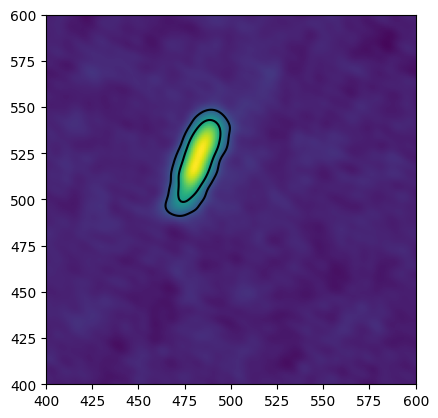

In [11]:
## [INPUT]
## Plot the contour of the disk. Choose appropriate contours.

disk_data_original = hdu_disk.data[0,0,:,:]
plt.imshow(disk_data_original,origin='lower')
contour1 = plt.contour(disk_data_original, cmap='inferno',levels=[0.2*np.nanmax(disk_data_original)])
contour2 = plt.contour(disk_data_original, cmap='inferno',levels=[0.5*np.nanmax(disk_data_original)])
contour_data1 = contour1.collections[0].get_paths()
contour_data2 = contour2.collections[0].get_paths()
plt.xlim(400,600)
plt.ylim(400,600)

In [12]:
## [INPUT]
## Documenting the sky coordinates of each point on the contour and convert it to image coordinates under the WCS axes of our data

from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel
# skycoord_to_pixel(pixel_to_skycoord([469,470], [491.69355761,491.69355761], WCS(hdu_disk.header)), wcs_ALMA)
for path in contour_data1:
    # print(path.vertices)
    coords_contour1_disk_ALMA = skycoord_to_pixel(pixel_to_skycoord(path.vertices[:,0], path.vertices[:,1], WCS(hdu_disk.header)), wcs_ALMA)
for path in contour_data2:
    # print(path.vertices)
    coords_contour2_disk_ALMA = skycoord_to_pixel(pixel_to_skycoord(path.vertices[:,0], path.vertices[:,1], WCS(hdu_disk.header)), wcs_ALMA)



indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in param

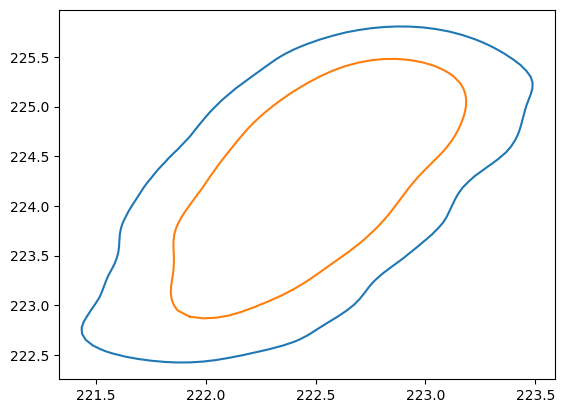

In [13]:
## Plot the contours to see if they match your expectation
plt.plot(coords_contour1_disk_ALMA[0],coords_contour1_disk_ALMA[1])
plt.plot(coords_contour2_disk_ALMA[0],coords_contour2_disk_ALMA[1])

#### Actual channel maps

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/var/folders/nt/5v93q0kd53nb6_gdg84kfk5w0000gn/T/ipykernel_7664/2317045686.py:39: RuntimeWarning: Mean of empty slice
  average_means = np.nanmean(


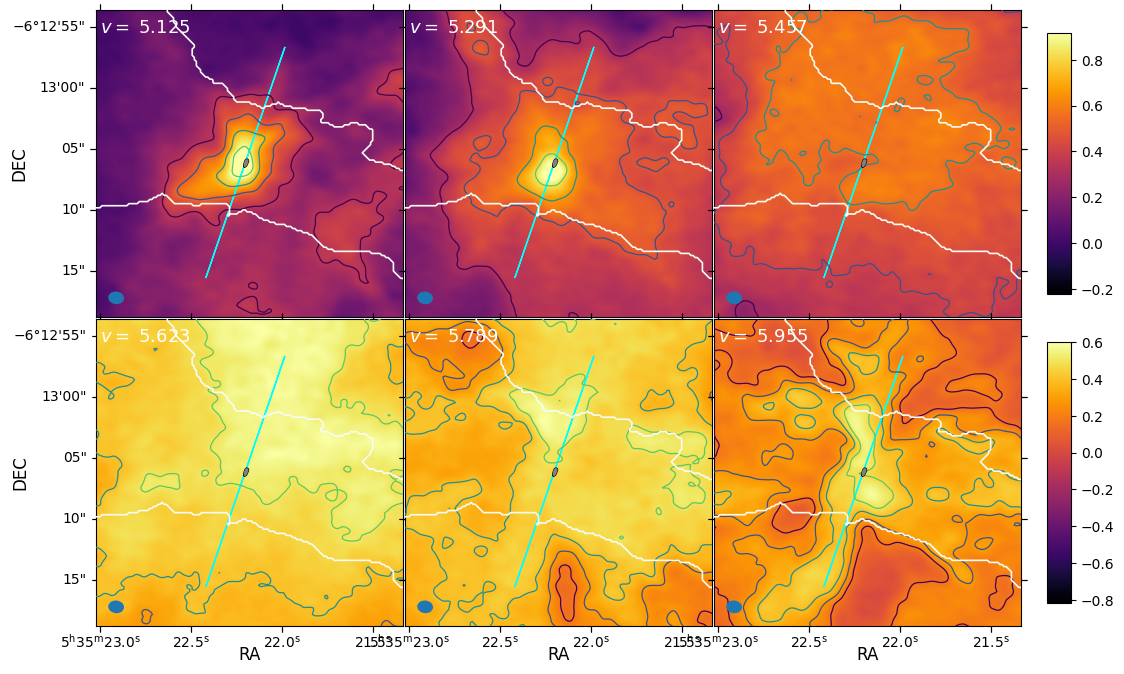

In [15]:
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import wcsaxes
from astropy.wcs import WCS
import numpy as np
import matplotlib.pyplot as plt
import math

# Define the channels to be plotted.
# In this example, we use a list of channels; you can adjust as needed.
channels = [62, 64, 66, 68, 70, 72]

# Determine the optimal grid dimensions (rows and columns) based on the number of channels.
# The function close_factors() returns factors that closely match the total number of channels.
n_row, n_col = close_factors(len(channels))[1], close_factors(len(channels))[0]

# Create a figure with a specified size.
fig = plt.figure(figsize=(12, 8))

# Set up an ImageGrid with WCS support.
# Each subplot will use the WCS information provided by the header of hdu_outflow.
grid = ImageGrid(fig, 111,
                 nrows_ncols=(n_row, n_col),
                 ngrids=None,
                 direction='row',
                 axes_pad=0.02,
                 share_all=True, aspect=True,
                 label_mode='L', cbar_mode=None,
                 axes_class=(wcsaxes.WCSAxes, dict({'wcs': WCS(hdu_outflow.header)})))

# Draw the canvas to initialize the grid.
plt.draw()

# Pre-calculate dynamic colormap limits for each row.
# For each row, average the data across the channels in that row to determine min and max values.
list_colormap = []
for index_row in range(n_row):
    # Create an array of images corresponding to the channels in the current row.
    average_means = np.nanmean(
        np.array([cube_data_ALMA[channels[j], :, :] for j in range(index_row * n_col, index_row * n_col + n_col)]),
        axis=0
    )
    # Set the colormap limits to slightly extend beyond the observed data range.
    list_colormap.append((0.95 * np.nanmin(average_means), 1.05 * np.nanmax(average_means)))
    # Alternative option (commented out) that prevents negative lower limits:
    # list_colormap.append((max(0, 0.9 * np.nanmin(average_means)), 1.05 * np.nanmax(average_means)))

# Define a margin value to set the limits for the displayed region of the image.
semia_fig = 150

# Loop over each subplot (axis) in the grid and plot the corresponding channel data.
for ax, i in zip(grid, range(len(grid))):
    # ----------------------------
    # Plotting Contours
    # ----------------------------
    # Define contour levels by creating 5 equally spaced levels between 30% and 100% of the maximum value for the channel.
    levels_channel = np.linspace(0.3, 1, 5) * np.nanmax(cube_data_ALMA[channels[i], :, :])
    # Plot the primary contours for the channel data using the 'viridis' colormap.
    ax.contour(cube_data_ALMA[channels[i], :, :], origin='lower',
               cmap='viridis', levels=levels_channel, linewidths=0.9)
    # Plot contours for regions where the outflow pixels exceed 0.4 times their standard deviation,
    # using the 'Greens' colormap.
    ax.contour(np.greater(M_outflow_pixel_onto_ALMA, 0.4 * np.nanstd(M_outflow_pixel_onto_ALMA)),
               cmap='Greens', linewidths=1.2)

    # Additional contour plotting for continuum or disk data is available, but commented out:
    # ax.contour(continuum_onto_ALMA, levels=[np.nanmax(continuum_onto_ALMA) * 0.5],
    #            cmap='viridis', linewidths=0.9)
    # ax.contour(disk_ALMA, levels=[0.2 * np.nanmax(disk_ALMA)],
    #            cmap='coolwarm', linewidths=1)
    # Plot disk contours using predefined coordinate arrays.
    ax.plot(coords_contour1_disk_ALMA[0], coords_contour1_disk_ALMA[1], color='black')
    ax.plot(coords_contour2_disk_ALMA[0], coords_contour2_disk_ALMA[1], color='grey')

    # ----------------------------
    # Displaying the Image Data
    # ----------------------------
    # Show the image for the current channel with the 'inferno' colormap.
    # The vmin and vmax values are set per row based on the pre-calculated colormap limits.
    im = ax.imshow(cube_data_ALMA[channels[i], :, :], origin='lower',
                   cmap='inferno',
                   vmin=list_colormap[int(math.floor(i / n_col))][0],
                   vmax=list_colormap[int(math.floor(i / n_col))][1])

    # ----------------------------
    # Overlaying Regions and Beam
    # ----------------------------
    # Plot the lines introduced earlier
    region_pix.plot(ax=ax, color='cyan')
    # Optionally, plot the disk axis (this line is commented out):
    # region_disk_axis.plot(ax=ax, color='black')

    # Add the telescope beam (resolution ellipse) using header parameters from hdu_ALMA.
    add_beam(ax, major=hdu_ALMA.header['BMAJ'],
             minor=hdu_ALMA.header['BMIN'],
             angle=hdu_ALMA.header['BPA'])

    # ----------------------------
    # Setting Axis Limits and Labels
    # ----------------------------
    # Retrieve the coordinate objects for RA (longitude) and DEC (latitude).
    lon = ax.coords[0]
    lat = ax.coords[1]
    # Disable the x-axis grid.
    ax.xaxis.grid(None)
    # Set the plot limits to focus on a central portion of the image defined by semia_fig.
    ax.set_xlim(semia_fig, 448 - semia_fig)
    ax.set_ylim(semia_fig, 448 - semia_fig)
    # Add a text label indicating the velocity corresponding to the current channel.
    # The velocity is calculated by transforming the pixel coordinate to world coordinates using wcs_ALMA.
    ax.text(semia_fig + 0.015 * (448 - semia_fig * 2),
            semia_fig + 0.925 * (448 - semia_fig - semia_fig),
            f"$v=$ {round(wcs_ALMA[:, 0, 0].pixel_to_world(channels[i]).value, 0)/1000}",
            size=13, color='white')

    # ----------------------------
    # Customizing Tick Labels
    # ----------------------------
    # For subplots not in the first column, reduce tick label size and hide y-axis labels.
    if i - math.floor(i / n_col) * n_col != 0:
        lon.set_ticks(size=4)
        lat.set_ticks(size=4)
        ax.tick_params('y', labelleft=False)
    else:
        # For the first column, set smaller ticks and display the DEC label.
        lat.set_ticks(size=3)
        lat.set_ticklabel(size=10)
        lat.set_axislabel('DEC', minpad=-0.4, size=12)
    # For subplots not in the bottom row, hide x-axis labels.
    if math.floor(i / n_col) != n_row - 1:
        lon.set_ticks(size=4)
        lat.set_ticks(size=4)
        ax.tick_params('x', labelleft=False)
    else:
        # For the bottom row, set tick sizes and display the RA label.
        lon.set_ticks(size=4)
        lon.set_ticklabel(size=10)
        lon.set_axislabel('RA', minpad=0.3, size=12)

    # ----------------------------
    # Adding Colorbars for Each Row
    # ----------------------------
    # For the last subplot in each row, add a vertical colorbar.
    if (i + 1) % n_col == 0:
        # Get the position of the current axis to position the colorbar appropriately.
        bbox_ax = grid[i].get_position()
        # Create an axis for the colorbar adjacent to the subplot.
        cbar_ax = fig.add_axes([0.92, bbox_ax.y0 + 0.075 * bbox_ax.height,
                                0.02, 0.85 * bbox_ax.height])
        # Add the colorbar to the figure.
        cbar = plt.colorbar(im, cax=cbar_ax)

# Display the final plot.
plt.show()

# Save the figure to a file with the specified resolution.
# fig.savefig('Disk_misalignment_small_scale.jpg', dpi=300)


### Average across channels

In [16]:
## [INPUT]
## Input the bounds of the channels you want to average over
channels_min = [56,59,62,64,66,68,70,72,75]
channels_max = [59,62,64,66,68,70,72,75,78]

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/var/folders/nt/5v93q0kd53nb6_gdg84kfk5w0000gn/T/ipykernel_7664/4143668453.py:37: RuntimeWarning: Mean of empty slice
  np.array([np.nanmean(cube_data_ALMA[channels_min[j]:channels_max[j], :, :], axis=0)
/var/folders/nt/5v93q0kd53nb6_gdg84kfk5w0000gn/T/ipykernel_7664/4143668453.py:36: RuntimeWarning: Mean of empty slice
  average_means = np.nanmean(
/var/folders/nt/5v93q0kd53nb6_gdg84kfk5w0000gn/T/ipykernel_7664/4143668453.py:52: RuntimeWarning: Mean of empty slice
  array_image = np.nanmean(cube_data_ALMA[channels_min[i]:channels_max[i], :, :], axis=0)
/var/folders/nt/5v93q0kd53nb6_gdg84kfk5w0000gn/T/ipykernel_7664/4143668453.py:52: RuntimeWarning: Mean of empty slice
  array_image = np.nanmean(cube_data_ALMA[channels_min[i]:channels_max[i], :, :], axis=0)
/var/folders/nt/5v93q0kd53nb6_gdg84kfk5w0000gn/T/ipykernel_7664/4143668453.py:52: RuntimeWarning: Mean of empty slice

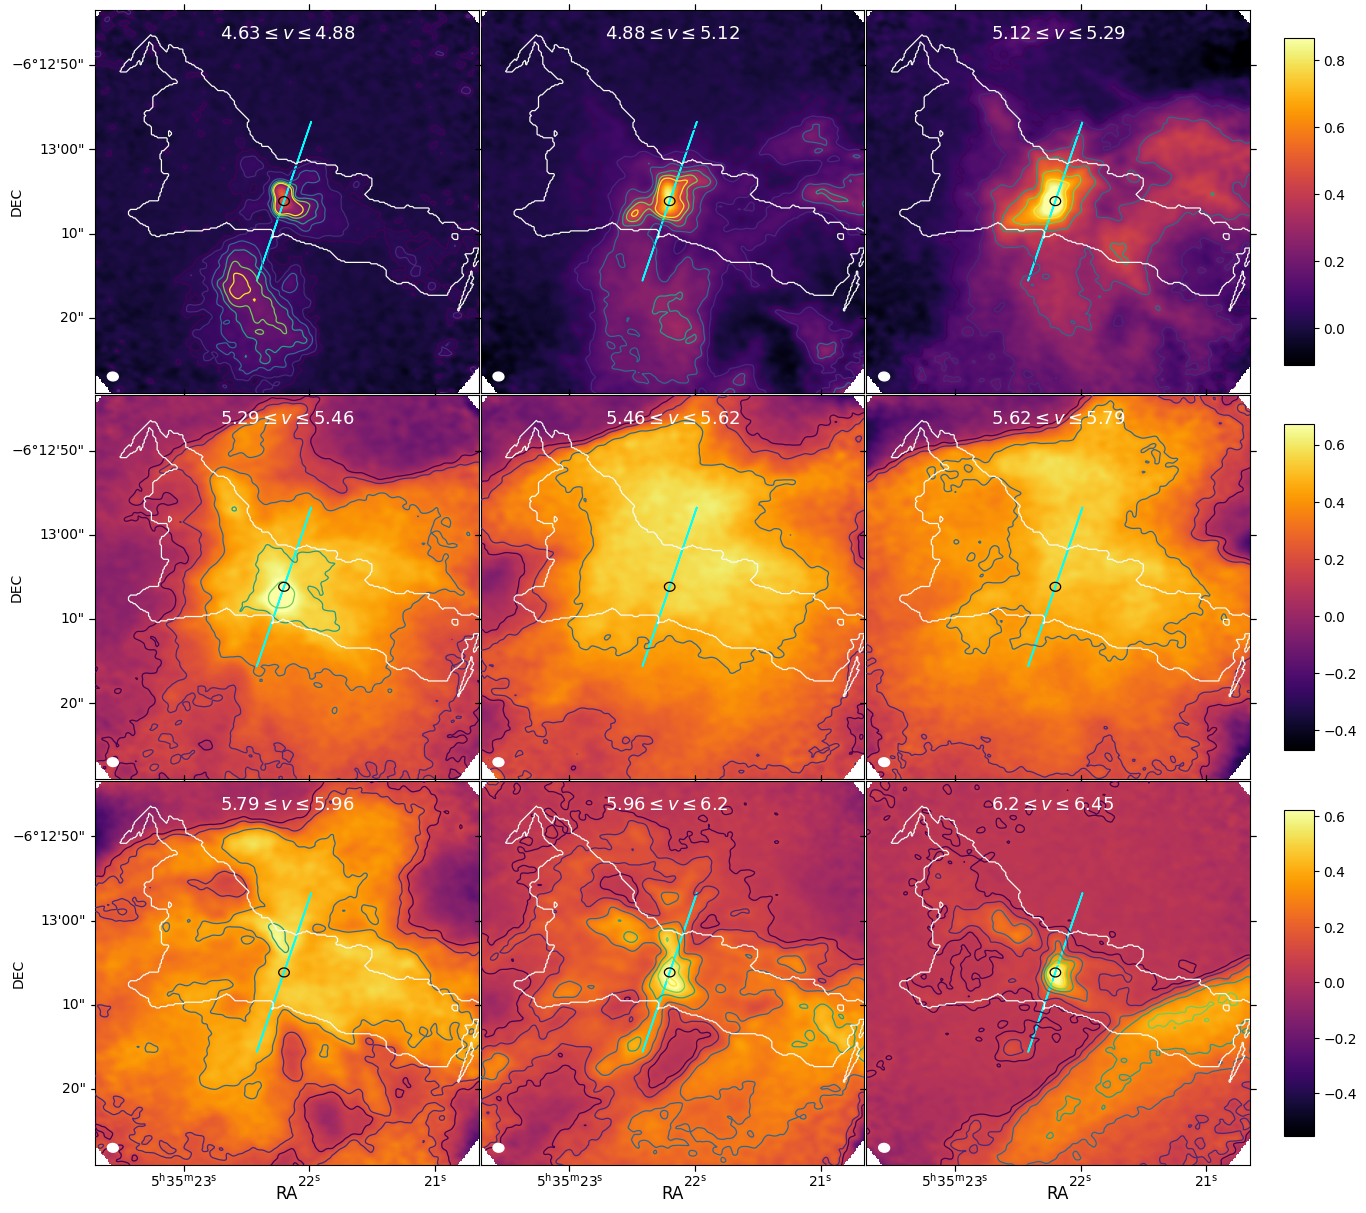

In [18]:
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization.wcsaxes import add_beam
from astropy.visualization import wcsaxes
from astropy.wcs import WCS
import numpy as np
import matplotlib.pyplot as plt
import math

# Determine grid dimensions based on the number of channels.
# close_factors() is assumed to return factors that best fit the total number of channels.
n_row, n_col = close_factors(len(channels_min))[1], close_factors(len(channels_max))[0]

# Create a figure with a specified size.
fig = plt.figure(figsize=(15, 15))

# Create an ImageGrid with WCS support.
# Each subplot uses the WCS information from hdu_outflow.header so that astronomical coordinates are properly represented.
grid = ImageGrid(fig, 111,
                 nrows_ncols=(n_row, n_col),
                 ngrids=None,
                 direction='row',
                 axes_pad=0.02,
                 share_all=True, aspect=True,
                 label_mode='L', cbar_mode=None,
                 axes_class=(wcsaxes.WCSAxes, dict({'wcs': WCS(hdu_outflow.header)})))


# Initialize the canvas to ensure the grid is fully drawn.
plt.draw()

# Pre-calculate dynamic colormap limits for each row.
# For each row, compute an average image by averaging over the channel data in that row.
list_colormap = []
for index_row in range(n_row):
    average_means = np.nanmean(
        np.array([np.nanmean(cube_data_ALMA[channels_min[j]:channels_max[j], :, :], axis=0)
                  for j in range(index_row * n_col, index_row * n_col + n_col)]),
        axis=0
    )
    # Set colormap limits slightly broader than the actual min and max values.
    list_colormap.append((0.95 * np.nanmin(average_means), 1.05 * np.nanmax(average_means)))
    # Alternative option (commented out) prevents negative lower limits:
    # list_colormap.append((max(0, 0.9 * np.nanmin(average_means)), 1.05 * np.nanmax(average_means)))

# Loop over each subplot (axis) in the grid and plot the corresponding channel data.
for ax, i in zip(grid, range(len(grid))):
    # ----------------------------
    # Contour Plotting
    # ----------------------------
    # Calculate the average image for the current channel range by taking the mean over the specified channels.
    array_image = np.nanmean(cube_data_ALMA[channels_min[i]:channels_max[i], :, :], axis=0)
    # Define contour levels using multiples of the standard deviation of the image.
    levels_channel = np.array([0.5, 1, 2, 3, 4, 5]) * np.nanstd(array_image)
    # Plot contours for the current channel image using the 'viridis' colormap.
    ax.contour(array_image, origin='lower', cmap='viridis', levels=levels_channel, linewidths=0.9)
    # Plot contours where the outflow pixel values exceed 0.4 times their standard deviation using the 'Greens' colormap.
    ax.contour(np.greater(M_outflow_pixel_onto_ALMA, 0.4 * np.nanstd(M_outflow_pixel_onto_ALMA)),
               cmap='Greens', linewidths=0.9)
    # Plot continuum contours at 50% of the continuum's maximum value with a grey colormap.
    ax.contour(continuum_onto_ALMA, levels=[np.nanmax(continuum_onto_ALMA) * 0.5],
               cmap='grey', linewidths=0.9)
    # Optionally, additional contours for disk data can be added (this line is commented out).
    # ax.contour(disk_ALMA, levels=[0.2 * np.nanmax(disk_ALMA)], cmap='coolwarm', linewidths=1)

    # ----------------------------
    # Displaying the Image
    # ----------------------------
    # Display the image data for the current channel range using the 'inferno' colormap.
    # The dynamic scaling is applied based on the pre-calculated colormap limits for the row.
    im = ax.imshow(array_image, origin='lower', cmap='inferno',
                   vmin=list_colormap[int(math.floor(i / n_col))][0],
                   vmax=list_colormap[int(math.floor(i / n_col))][1])

    # ----------------------------
    # Plotting Lines and Beam Annotation
    # ----------------------------
    # Plot the lines introduced earlier
    region_pix.plot(ax=ax, color='cyan', linewidth=1.2)

    # Add the telescope beam (resolution indicator) to the image using header parameters.
    add_beam(ax, major=hdu_ALMA.header['BMAJ'], minor=hdu_ALMA.header['BMIN'],
             angle=hdu_ALMA.header['BPA'], color='white')

    # ----------------------------
    # Setting Axis Limits and Labels
    # ----------------------------
    # Retrieve the coordinate objects (longitude and latitude) for the axis.
    lon = ax.coords[0]
    lat = ax.coords[1]
    # Disable the default x-axis grid.
    ax.xaxis.grid(None)
    # Define a margin to focus on a central region of the image.
    a_fig = 90
    ax.set_xlim(a_fig, 448 - a_fig)
    ax.set_ylim(a_fig, 448 - a_fig)
    # Add a text label to the subplot showing the velocity range for the channel.
    ax.text(a_fig + 0.325 * (448 - a_fig - a_fig),
            a_fig + 0.925 * (448 - a_fig - a_fig),
            f"$ {round(v_ALMA[channels_min[i]], 2)} \\leq v \\leq {round(v_ALMA[channels_max[i]], 2)}$",
            size=13, color='white')

    # ----------------------------
    # Customizing Tick Labels
    # ----------------------------
    # For subplots not in the first column, reduce tick size and hide y-axis labels.
    if i - math.floor(i / n_col) * n_col != 0:
        lon.set_ticks(size=4)
        lat.set_ticks(size=4)
        ax.tick_params('y', labelleft=False)
    else:
        # For the first column, set smaller tick sizes and add a DEC label.
        lat.set_ticks(size=3)
        lat.set_ticklabel(size=10)
        lat.set_axislabel('DEC', minpad=-0.4, size=10)
    # For subplots not in the bottom row, hide x-axis tick labels.
    if math.floor(i / n_col) != n_row - 1:
        lon.set_ticks(size=4)
        lat.set_ticks(size=4)
        ax.tick_params('x', labelleft=False)
    else:
        # For the bottom row, set tick sizes and add an RA label.
        lon.set_ticks(size=4)
        lon.set_ticklabel(size=10)
        lon.set_axislabel('RA', minpad=0.3, size=12)

    # ----------------------------
    # Adding Colorbars
    # ----------------------------
    # For the last subplot in each row, add a vertical colorbar.
    if (i + 1) % n_col == 0:
        # Get the bounding box of the current axis to correctly position the colorbar.
        bbox_ax = grid[i].get_position()
        # Create a new axes for the colorbar positioned to the right of the current subplot.
        cbar_ax = fig.add_axes([0.92, bbox_ax.y0 + 0.075 * bbox_ax.height,
                                0.02, 0.85 * bbox_ax.height])
        # Add the colorbar for the image.
        cbar = plt.colorbar(im, cax=cbar_ax)

# Display the final figure.
plt.show()
# Optionally, save the figure to a file with the specified DPI.
# fig.savefig('/Users/donglinwu/Desktop/College/Research/Figures/13CO_channel_maps.jpg', dpi=300)